# Анализ результатов A/B-тестирования нового интрефейса интернет-магазина
13.06.2025

## Вводные данные

Интернет-магазина BitMotion Kit продает геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория и хиты продаж. 

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача — провести оценку результатов A/B-теста. В распоряжении аналитика:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Необходимо оценить корректность проведения теста и проанализировать его результаты.

## Цель исследования

**Цель исследования**: проверить результаты А/В теста, подтвердить или опровергнуть гипотезу, что новый интерфейс сайта интернет-магазина BitMotion Kit в течение 7 дней после регистрации в системе повысил конверсию зарегистрированных пользователей в покупку не меньше, чем на 3%.

## План работы
<font color='#777778'>

* Загрузка библиотек

* Загрузка данных и оценка их целостности
      
* Оценка корректности проведения теста 

* Анализ данных о пользовательской активности 
    
* Расчет параметров А/В теста
    
* Оценка результатов А/В тестирования

* Вывод
    
  
</font>

## Загрузка библиотек¶

In [1]:
#загружаем нужные для работы библиотеки и функции
import pandas as pd

In [2]:
from datetime import date, timedelta

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Библиотека для диаграмм Венна
from matplotlib_venn import venn2

In [5]:
from statsmodels.stats.proportion import proportions_ztest

## Загрузка данных и оценка их целостности


In [6]:
try:
    participants = pd.read_csv('datasets/ab_test_participants.csv')
    events = pd.read_csv('datasets/ab_test_events.csv',
                     parse_dates=['event_dt'], low_memory=False)
    display('Файлы загружены успешно')
except:
    deisplay('Ошибка загрузки')

'Файлы загружены успешно'

In [7]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [8]:
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [9]:
## проверим пользователей на полные дубликаты
display(f'Полных дубликатов {participants.duplicated().sum()} строк')

'Полных дубликатов 0 строк'

Датафрейм **participants** содержит 14525 строк и 4 столбца, хранит данные о пользователях, участвующих в разных А/В тестах и устройствах, с помощью которых пользователи заходят в приложение. Пропуски в данных - отсутствуют. Полных дубликатов - нет.

In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [11]:
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [12]:
## проверим события на полные дубликаты
display(f'Полных дубликатов {events.duplicated().sum()} строк')

'Полных дубликатов 36318 строк'

In [13]:
# т.к. дата события содержит также и время, то маловероятно, что это разные события, удалим полные дубликаты
events = events.drop_duplicates()
events.shape[0]

750968

После удаления полных дубликатов датафрейм **events** содержит 750968 строк и 4 столбца, хранит данные о действиях пользователя в приложении. Пропуски в данных присутствуют только в столбце 'details' - стоимость привлечения клиента и стоимость покупки клиентом.

## Оценка корректности проведения теста

По таблице `ab_test_participants` выделим пользователей, участвующих в тесте, и проверим:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [14]:
#разбиваем пользователей на группы
set_users_A = set(participants['user_id'].loc[(participants['group'] == 'A') & (participants['ab_test'] == 'interface_eu_test')])
set_users_B = set(participants['user_id'].loc[(participants['group'] == 'B') & (participants['ab_test'] == 'interface_eu_test')])

Проверим пересечения пользователей

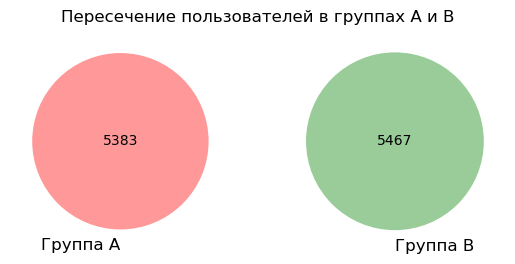

In [15]:
# Визуализируем пересечения пользователей в группах (диаграмма Венна)
v = venn2(subsets=[set_users_A, set_users_B], \
          set_labels=('Группа А', 'Группа B'))
plt.title("Пересечение пользователей в группах А и В")
plt.show()   

In [16]:
display(f'Между группами существует пересечение в количестве {len(set_users_A.intersection(set_users_B))} пользователей')

'Между группами существует пересечение в количестве 0 пользователей'

In [17]:
# разбиваем на группы в соответствии с получившимися множествами ID пользователей
# помним, что пользователи могут участовать в разных тестах, нам нужен 'interface_eu_test'
group_A = participants.loc[participants['user_id'].isin(set_users_A) & (participants['ab_test'] == 'interface_eu_test')]
group_B = participants.loc[participants['user_id'].isin(set_users_B) & (participants['ab_test'] == 'interface_eu_test')]

In [18]:
#проверим на дубликаты по ID пользователя
display(f'Дубликатов по ID пользователя в группе A {group_A.duplicated(subset = ["user_id"]).sum()} строк')
display(f'Дубликатов по ID пользователя в группе B {group_B.duplicated(subset = ["user_id"]).sum()} строк')

'Дубликатов по ID пользователя в группе A 0 строк'

'Дубликатов по ID пользователя в группе B 0 строк'

In [19]:
#считаем количество пользователей в группе А
count_users_A = group_A['user_id'].nunique()
display(f'Количество пользователей в группе А: {count_users_A}')

'Количество пользователей в группе А: 5383'

In [20]:
#считаем количество пользователей в группе B
count_users_B = group_B['user_id'].nunique()
display(f'Количество пользователей в группе B: {count_users_B}')

'Количество пользователей в группе B: 5467'

Проверим соотношение количества пользователей между группами.

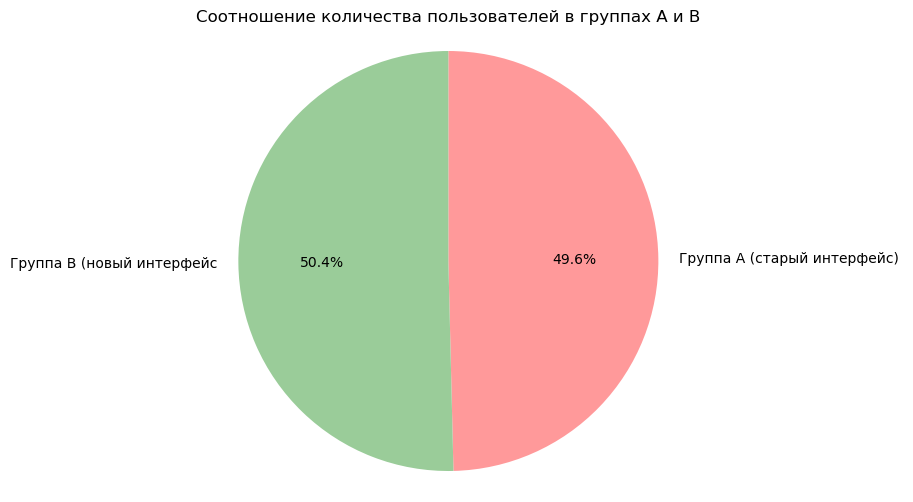

In [21]:
#строим круговую диаграмму
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([count_users_A,count_users_B], labels=['Группа А (старый интерфейс) ','Группа В (новый интерфейс'], autopct='%1.1f%%', startangle=90,\
        colors=['#ff999a','#9acc99'], counterclock=False)
plt.axis('equal')
ax.set_title('Соотношение количества пользователей в группах А и В')
plt.show()

**Вывод:** Выборки сопоставимы по размерам, пересечений между группами - нет.

## Анализ данных о пользовательской активности 

Анализируем таблицу `ab_test_events`. Оставим только события, связанные с участвующими в изучаемом тесте пользователями

В тесте изучаются только события "registration" (регистрация) и "purchase" (покупка). Выделим эти данные.

In [22]:
events = events.loc[(events['event_name'] == 'registration') | (events['event_name'] == 'purchase')]
events.shape[0]

244902

Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [23]:
#добавим новый столбец "Дней после регистрации"
events.insert(4, 'days_after_registration', 0 )

In [24]:
#выберем всех пользователей с датой регистрации в отдельный датафрейм
df_days_registration = events.loc[events['event_name'] == 'registration',['user_id','event_dt']]

In [25]:
#Объединим events с таблицей с датой регистрации и заполним столбец с количеством дней после рагистрации для всех записей
events = pd.merge(events,df_days_registration, on='user_id', how='left')

In [26]:
events.head()

,user_id,event_dt_x,event_name,details,days_after_registration,event_dt_y
0,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0,0,2020-12-01 00:00:11
1,AA346F4D22148024,2020-12-01 00:01:46,registration,-2.0,0,2020-12-01 00:01:46
2,7EF01D0E72AF449D,2020-12-01 00:02:06,registration,-5.0,0,2020-12-01 00:02:06
3,9A6276AD14B14252,2020-12-01 00:02:20,registration,-2.0,0,2020-12-01 00:02:20
4,9B186A3B1A995D36,2020-12-01 00:02:37,registration,-3.5,0,2020-12-01 00:02:37


In [27]:
#заполним столбец - сколько прошло дней после регистрации
events['days_after_registration'] =  events['event_dt_x'] - events['event_dt_y']
events['days_after_registration'] = events['days_after_registration'].dt.days

In [28]:
#Выбираем записи за неделю после регистрации, дата регистрации - день 0
events = events.loc[events['days_after_registration'] <=6]

In [29]:
#проверяем - как заполнились поля с датой
events.loc[(events['event_name'] == 'purchase') & (events['days_after_registration'] > 0)].head()

,user_id,event_dt_x,event_name,details,days_after_registration,event_dt_y
5344,4C84A105980845F0,2020-12-03 01:41:09,purchase,9.99,1.0,2020-12-01 22:36:01
6129,C8398D407BED4CF6,2020-12-03 08:41:34,purchase,4.99,1.0,2020-12-01 17:23:01
7508,ABED3FCF96875443,2020-12-03 21:16:24,purchase,4.99,1.0,2020-12-02 15:00:44
13602,0662C037790B42CF,2020-12-05 03:06:42,purchase,4.99,1.0,2020-12-04 02:47:13
13934,8FF826EAD7F6431F,2020-12-05 04:32:03,purchase,4.99,1.0,2020-12-04 02:04:13


In [30]:
#объединяем пользователей и события
group_A = pd.merge(group_A, events, on='user_id' , how='inner' )
group_A.shape[0]

8133

In [31]:
group_B = pd.merge(group_B, events, on='user_id' , how='inner' )
group_B.shape[0]

8986

## Расчет параметров А/В теста

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. 

Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Проверка достаточности выборки проводилась с помощью калькулятора Эвана Миллера (ниже вставлена картинка). Калькулятор показал, что при заданных параметрах каждая группа должна иметь размер выборки = 3692. Рассчитаем размеры групп для 7-дневного теста.

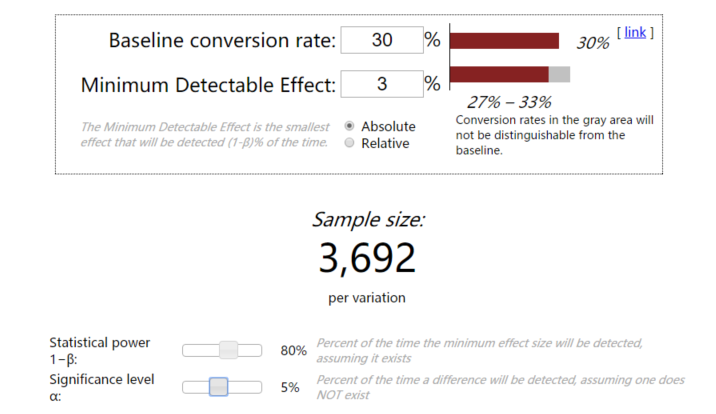

Рассчитаем для каждой тестовой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [32]:
# посчитаем размер группы А
n_A = group_A['user_id'].nunique()
display(f'Размер группы А = {n_A}')

'Размер группы А = 5383'

In [33]:
# посчитаем размер группы B
n_B = group_B['user_id'].nunique()
display(f'Размер группы B = {n_B}')

'Размер группы B = 5467'

Размер выборки достаточен для получения статистически значимых результатов 

In [34]:
# посчитаем кол-во успехов (покупок) в группе A
m_A = group_A.loc[group_A['event_name'] =='purchase']['user_id'].nunique()
display(f'Количество посетителей, сделавших покупку в группе А = {m_A}')

'Количество посетителей, сделавших покупку в группе А = 1480'

In [35]:
# посчитаем кол-во успехов (покупок) в группе B
m_B = group_B.loc[group_B['event_name'] =='purchase']['user_id'].nunique()
display(f'Количество посетителей, сделавших покупку в группе В = {m_B}')

'Количество посетителей, сделавших покупку в группе В = 1600'

Оценим предварительно пользовательскую активность в тестовой группе по сравнению с контрольной.

In [36]:
# считаеv доли успехов для каждой группы: A и B
p_A, p_B = m_A/n_A, m_B/n_B 
display(f'Доли успехов (конверсий) в группах: A:{p_A}, B:{p_B}')

'Доли успехов (конверсий) в группах: A:0.27493962474456624, B:0.29266508139747577'

In [37]:
# Считаем разницу между группами в процентных пунктах
display(f'Конверсия в покупку в контрольной группе A = {round(p_A * 100, 2)}%')
display(f'Конверсия в покупку в тестовой группе B = {round(p_B * 100,2)}%')

if p_A >= p_B:
    display(f'В контрольной группе A конверсия больше, чем в тестовой группе В на {round((p_A * 100) - (p_B * 100),2)} процентных пунктов')
else: 
    display(f'В тестовой группе В конверсия больше, чем в контрольной А на {round((p_B * 100) - (p_A * 100), 2)} процентных пунктов')   

'Конверсия в покупку в контрольной группе A = 27.49%'

'Конверсия в покупку в тестовой группе B = 29.27%'

'В тестовой группе В конверсия больше, чем в контрольной А на 1.77 процентных пунктов'

## Оценка результатов A/B-тестирования

Проверим изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез. Для анализа доли успехов(покупок) в выборках используем Z-тест пропорций.

In [38]:
# Сначала проверим предпосылку о достаточном количестве данных в выборках А и В
if (p_A*n_A > 10) and ((1-p_A)*n_A > 10) and (p_B*n_B > 10) and ((1-p_B)*n_B > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


Формулируем гипотезы:
+ Нулевая гипотеза H₀: конверсия зарегистрированных пользователей в покупателей не увеличится с упрощением интерфейса.
+ Альтернативная гипотеза H₁: конверсия зарегистрированных пользователей в покупателей увеличится с упрощением интерфейса.

In [39]:
alpha = 0.05 ## уровень значимости

# [m_A, m_B] - массивы из количества успехов
# [n_A, n_B] - массивы размеров выборок
# H0 - конверсия в тестовой выборке меньше, чем в контрольной pA > PB
# H1 - конверсия в тестовой выборке больше, чем в контрольной pA < PB

stat_ztest, p_value_ztest = proportions_ztest([m_A, m_B],[n_A, n_B], alternative='smaller')

print(f'pvalue={p_value_ztest}') # полученное p-value 

if p_value_ztest >= alpha:
    print('Нулевая гипотеза находит подтверждение! Конверсия в тестовой выборке В меньше, чем в контрольной А')
else:
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу: конверсия в тестовой выборке В больше, чем в контрольной А.')


pvalue=0.020306993983065475
Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу: конверсия в тестовой выборке В больше, чем в контрольной А.


## Вывод

1. Суть проводимого А/В теста: Гипотеза: новый интерфейс сайта интернет-магазина BitMotion Kit увеличит конверсию в покупку на 3%. Ключевая метрика - конверсия. Длительность эксперимента: 7 дней, количество пользователей в группах сопоставимо: в группе А - 5383(49,6%), в группе В - 5467(50,4%) человек.

2. По результатам теста выявлено, что внедрение нового интерфейса сайта увеличило ключевую метрику (конверсию в покупку) в тестовой группе на 6,45%.

3. Значение p-value для оценки статистической значимости выявленного эффекта составляет 0.020306993983065475, что меньше уровня значимости = 0.05. 

4. Предполагаемый минимальный детектируемый эффект (MDE) = 3%, a реальный MDE - разница между контрольной и тестовой группами в результате эксперимента составила 1,77%. 

**Вывод**: да, изменения в тестовой группе статистически зафиксированы, но эксперимент не показал ожидаемых результатов. Повышения конверсии на 3% в тестовой группе не произошло. 

**Рекомендация:**

а) оставить интерфейс сайта как есть;

б) доработать гипотезу: снизить MDE эксперимента;

в) провести более длительный эксперимент, т.к., возможно, не все потенциальные покупатели заходили на сайт. 